## 1. 读取图片

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

<function matplotlib.pyplot.show(close=None, block=None)>

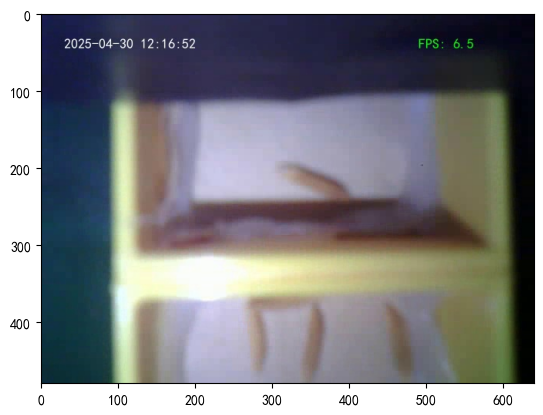

In [50]:
import cv2
import numpy as np
from collections import deque

# 读取图片（替换为你的实际路径）
image_path = r"C:\Users\lenovo\Desktop\esp32\esp32\esp32cam_viewer\data\vids\vid_20250430_12_16_33_339\frame_0117.jpg"
frame = cv2.imread(image_path)
assert frame is not None, "图片读取失败，请检查路径"

# 显示原始图像
cv2.imshow('Original Frame', frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_frame)
plt.show

## 2. 图像预处理

### 2.1 转换HSV观察颜色阈值

<function matplotlib.pyplot.show(close=None, block=None)>

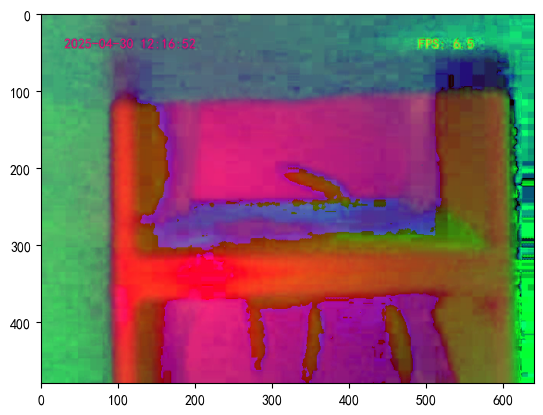

In [51]:
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
cv2.imshow('hsv', hsv)
cv2.waitKey(0)
cv2.destroyAllWindows()

rgb_hsv = cv2.cvtColor(hsv, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_hsv)
plt.show

### 2.2 交互取色盘

In [12]:
import cv2
import numpy as np

def calibrate_hsv_realtime(image_path):
    # 读取图像
    frame = cv2.imread(image_path)
    original_frame = frame.copy() # 保存原始图像，用于重置
    if frame is None:
        print(f"错误：无法读取图像 {image_path}")
        return
    
    # 转换到HSV颜色空间
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # 创建显示窗口
    window_name = "HSV Calibration (Move Mouse, Press 'c' to Clear)"
    cv2.namedWindow(window_name)
    
    # --- 存储绘制状态 ---
    drawn_dots = []      # 存储所有单击绘制的点 [(x, y), ...]
    drawn_lines = []     # 存储所有拖动绘制的线 [[(x1,y1), (x2,y2),...], ...]
    current_line = []    # 存储当前正在拖动的线
    is_drawing = False   # 标记是否正在按下鼠标左键拖动
    last_mouse_pos = (0, 0) # 记录最后鼠标位置，用于清除后刷新
    
    # --- 辅助函数：在图像上绘制所有持久化的点和线 ---
    def draw_persistent_elements(target_image):
        # 绘制所有存储的点
        for point in drawn_dots:
            cv2.circle(target_image, point, 3, (0, 0, 255), -1) # 红色实心圆点
        # 绘制所有存储的线
        for line in drawn_lines:
            if len(line) > 1:
                for i in range(1, len(line)):
                    cv2.line(target_image, line[i-1], line[i], (0, 0, 255), 2) # 红色线

    # --- 辅助函数：绘制通用信息（文本、十字线、预览） ---
    def draw_info(target_image, x, y, bgr_val, hsv_val):
         # 显示当前点数值信息
        text1 = f"B: {bgr_val[0]} G: {bgr_val[1]} R: {bgr_val[2]}"
        text2 = f"H: {hsv_val[0]} S: {hsv_val[1]} V: {hsv_val[2]}"
        text3 = f"coord: ({x},{y})"
        cv2.putText(target_image, text1, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
        cv2.putText(target_image, text2, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
        cv2.putText(target_image, text3, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)
        # 绘制十字准线
        cv2.line(target_image, (x, 0), (x, frame.shape[0]), (0, 255, 0), 1)
        cv2.line(target_image, (0, y), (frame.shape[1], y), (0, 255, 0), 1)
        # 显示当前像素的小预览
        preview_size = 50
        cv2.rectangle(target_image, (10, 110), (10+preview_size, 110+preview_size), tuple(map(int, bgr_val)), -1)

    # --- 鼠标回调函数 ---
    def on_mouse(event, x, y, flags, param):
        nonlocal display, drawn_dots, drawn_lines, current_line, is_drawing, last_mouse_pos
        
        last_mouse_pos = (x, y) # 持续更新最后鼠标位置

        # 确保坐标在图像范围内
        if 0 <= x < frame.shape[1] and 0 <= y < frame.shape[0]:
            # 获取HSV和BGR值
            hsv_val = hsv[y, x]
            bgr_val = frame[y, x]
            
            # 1. 准备显示图像：从原始帧开始
            display = original_frame.copy()
            
            # 2. 绘制所有已存储的持久化元素
            draw_persistent_elements(display)
            
            # 3. 处理鼠标事件和绘制当前交互
            if event == cv2.EVENT_LBUTTONDOWN:
                is_drawing = True
                current_line = [(x, y)]  # 开始记录新线段(或点)
                # 临时绘制起点反馈（可选，可以去掉）
                # cv2.circle(display, (x, y), 3, (0, 255, 255), -1) 

            elif event == cv2.EVENT_MOUSEMOVE:
                if is_drawing:
                    current_line.append((x, y))
                    # 实时绘制当前正在拖动的线段（在持久化元素之上）
                    if len(current_line) > 1:
                        for i in range(1, len(current_line)):
                           cv2.line(display, current_line[i-1], current_line[i], (0, 0, 255), 2) # 使用红色实时绘制

            elif event == cv2.EVENT_LBUTTONUP:
                if is_drawing: # 只有在按下状态松开才处理
                    is_drawing = False
                    if len(current_line) == 1:
                        # --- 单击事件 ---
                        drawn_dots.append(current_line[0])
                        # # 绘制刚添加的点（其实draw_persistent_elements会处理，这里可以省略）
                        # cv2.circle(display, current_line[0], 3, (0, 0, 255), -1)
                        print(f"\n标记点: ({current_line[0][0]}, {current_line[0][1]})")
                        print(f"  BGR: [{bgr_val[0]}, {bgr_val[1]}, {bgr_val[2]}]")
                        print(f"  HSV: [{hsv_val[0]}, {hsv_val[1]}, {hsv_val[2]}]")

                    elif len(current_line) > 1:
                        # --- 拖动释放事件 ---
                        drawn_lines.append(list(current_line)) # 将当前线添加到永久线列表中
                        
                        # --- 计算统计信息 ---
                        bgr_values = np.array([original_frame[p[1], p[0]] for p in current_line])
                        hsv_values = np.array([hsv[p[1], p[0]] for p in current_line])
                        
                        b_mean, b_std = np.mean(bgr_values[:, 0]), np.std(bgr_values[:, 0])
                        g_mean, g_std = np.mean(bgr_values[:, 1]), np.std(bgr_values[:, 1])
                        r_mean, r_std = np.mean(bgr_values[:, 2]), np.std(bgr_values[:, 2])
                        h_mean, h_std = np.mean(hsv_values[:, 0]), np.std(hsv_values[:, 0])
                        s_mean, s_std = np.mean(hsv_values[:, 1]), np.std(hsv_values[:, 1])
                        v_mean, v_std = np.mean(hsv_values[:, 2]), np.std(hsv_values[:, 2])

                        # --- 在图像上显示统计信息 ---
                        y_pos = 180
                        cv2.putText(display, "=== BGR Statistics ===", (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2); y_pos += 30
                        cv2.putText(display, f"B: Mean={b_mean:.1f}, Std={b_std:.1f}", (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2); y_pos += 30
                        cv2.putText(display, f"G: Mean={g_mean:.1f}, Std={g_std:.1f}", (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2); y_pos += 30
                        cv2.putText(display, f"R: Mean={r_mean:.1f}, Std={r_std:.1f}", (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2); y_pos += 30
                        cv2.putText(display, "=== HSV Statistics ===", (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2); y_pos += 30
                        cv2.putText(display, f"H: Mean={h_mean:.1f}, Std={h_std:.1f}", (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2); y_pos += 30
                        cv2.putText(display, f"S: Mean={s_mean:.1f}, Std={s_std:.1f}", (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2); y_pos += 30
                        cv2.putText(display, f"V: Mean={v_mean:.1f}, Std={v_std:.1f}", (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2); y_pos += 30
                        cv2.putText(display, f"Total Points: {len(current_line)}", (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)

                        # --- 打印到控制台 ---
                        print("\n=== Line Statistics ===")
                        print(f"B: Mean={b_mean:.1f}, Std={b_std:.1f}")
                        print(f"G: Mean={g_mean:.1f}, Std={g_std:.1f}")
                        print(f"R: Mean={r_mean:.1f}, Std={r_std:.1f}")
                        print(f"H: Mean={h_mean:.1f}, Std={h_std:.1f}")
                        print(f"S: Mean={s_mean:.1f}, Std={s_std:.1f}")
                        print(f"V: Mean={v_mean:.1f}, Std={v_std:.1f}")
                        print(f"Total Points: {len(current_line)}")

                    current_line = [] # 清空当前线

            # 4. 绘制十字线、文本信息等（在所有元素之上）
            draw_info(display, x, y, bgr_val, hsv_val)

            # 5. 更新显示
            cv2.imshow(window_name, display)
        
        # --- 如果鼠标移出窗口，可能需要刷新以移除十字线 ---
        # (或者在每次循环开始时根据last_mouse_pos重绘)

    # 设置鼠标回调
    cv2.setMouseCallback(window_name, on_mouse)
    
    # 初始显示（无绘制元素，无交互信息）
    display = original_frame.copy()
    cv2.imshow(window_name, display)
    
    print("移动鼠标查看像素值，单击绘制红点，拖动绘制线段，按 'c' 清除绘制，按其他任意键退出...")

    # --- 主循环，处理按键 ---
    while True:
        key = cv2.waitKey(1) & 0xFF # 等待1ms按键

        if key == ord('c') or key == ord('C'):
            print("清除所有绘制...")
            drawn_dots.clear()
            drawn_lines.clear()
            
            # 清除后立即刷新显示
            display = original_frame.copy() # 重置为原始图像
            # 使用最后鼠标位置重新绘制信息（十字线、文本等）
            lx, ly = last_mouse_pos
            if 0 <= lx < frame.shape[1] and 0 <= ly < frame.shape[0]:
                 lhsv = hsv[ly, lx]
                 lbgr = original_frame[ly, lx]
                 draw_info(display, lx, ly, lbgr, lhsv)
            cv2.imshow(window_name, display)

        # 检查是否按了退出键 (除了 'c'/'C' 和无按键之外的任何键)
        elif key != 255 and key != ord('c') and key != ord('C'):
             break 

        # 检查窗口是否被关闭
        if cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE) < 1:
             break
             
    cv2.destroyAllWindows()

# 使用示例
# 请确保路径正确
image_path = r"C:\Users\lenovo\Desktop\esp32\esp32\esp32cam_viewer\data\vids\vid_20250430_12_16_33_339\frame_0008.jpg" 
calibrate_hsv_realtime(image_path)

移动鼠标查看像素值，单击绘制红点，拖动绘制线段，按 'c' 清除绘制，按其他任意键退出...

=== Line Statistics ===
B: Mean=128.8, Std=21.2
G: Mean=157.4, Std=25.7
R: Mean=155.3, Std=27.9
H: Mean=32.4, Std=4.3
S: Mean=47.2, Std=13.4
V: Mean=158.3, Std=26.5
Total Points: 332

=== Line Statistics ===
B: Mean=204.6, Std=22.6
G: Mean=250.5, Std=6.1
R: Mean=238.6, Std=11.5
H: Mean=43.8, Std=19.7
S: Mean=47.2, Std=20.1
V: Mean=250.5, Std=6.1
Total Points: 262

=== Line Statistics ===
B: Mean=61.8, Std=21.8
G: Mean=111.9, Std=18.4
R: Mean=92.9, Std=14.7
H: Mean=42.0, Std=7.9
S: Mean=117.7, Std=24.4
V: Mean=111.9, Std=18.4
Total Points: 251

=== Line Statistics ===
B: Mean=127.5, Std=12.5
G: Mean=140.1, Std=9.3
R: Mean=162.1, Std=9.8
H: Mean=27.1, Std=48.2
S: Mean=54.8, Std=18.6
V: Mean=162.1, Std=9.8
Total Points: 548


### 2.3 HSV阈值确定

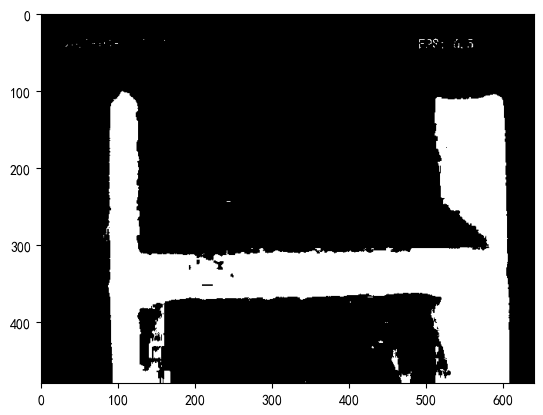

In [52]:
h_d = 20
h_u = 100   # 上限 = h_d + 48.2
s_d = 0
s_u = 160    # 上限 = s_d + 18.6
v_d = 100
v_u = 255    # 上限 = v_d + 9.8

# 确保 HSV 范围在有效范围内（H: 0-180, S: 0-255, V: 0-255）
lower_bound = np.array([max(0, h_d), max(0, s_d), max(0, v_d)])
upper_bound = np.array([min(180, h_u), min(255, s_u), min(255, v_u)])

# 转换为 HSV 色彩空间
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

# 创建 HSV 掩膜
hsv_mask = cv2.inRange(hsv, lower_bound, upper_bound)

# 显示原始 HSV 图像和掩膜结果
cv2.imshow('HSV Image', hsv)
cv2.imshow('HSV Mask', hsv_mask)

cv2.waitKey(0)
cv2.destroyAllWindows()

plt.imshow(hsv_mask,cmap = "gray")
plt.show()

## 3. 最大矩型外轮廓查询与分割

Extracted ROI 的面积: 64487.0 像素


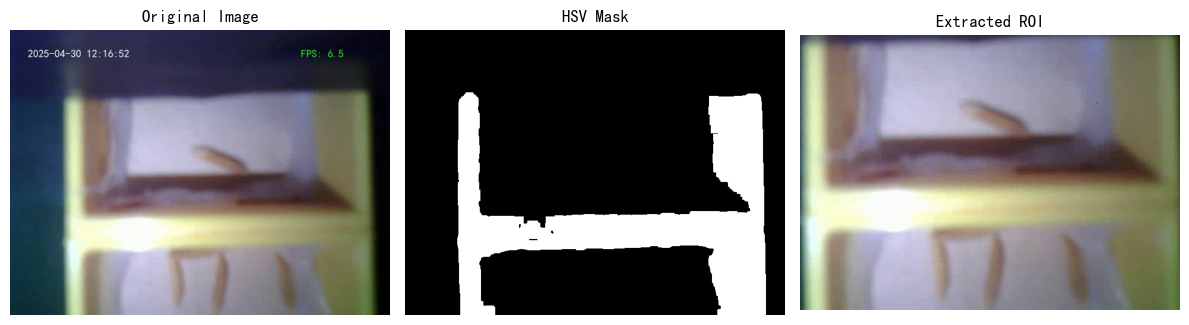

In [126]:
# 形态学操作——去噪点与填充
kernel = np.ones((5, 5), np.uint8)
# 手动实现开运算（腐蚀 + 膨胀），并指定迭代次数
iterations = 3  # 腐蚀和膨胀各执行 2 次
hsv_mask_eroded = cv2.erode(hsv_mask, kernel, iterations=iterations)
hsv_mask = cv2.dilate(hsv_mask_eroded, kernel, iterations=iterations)

# 查找轮廓
contours, _ = cv2.findContours(hsv_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 找到最大轮廓
if contours:
    max_contour = max(contours, key=cv2.contourArea)
    
    # 获取外接矩形
    x, y, w, h = cv2.boundingRect(max_contour)
    
    # 在原图上绘制矩形
    frame_with_rect = frame.copy()
    cv2.rectangle(frame_with_rect, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    # 分割出矩形区域
    roi = frame[y:y+h, x:x+w]
    contour_area = cv2.contourArea(max_contour)
    print(f"Extracted ROI 的面积: {contour_area} 像素")
    
    # 显示结果
    cv2.imshow('Original with Bounding Box', frame_with_rect)
    cv2.imshow('ROI', roi)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    # 使用matplotlib显示
    plt.figure(figsize=(12, 6))
    
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(hsv_mask, cmap='gray')
    plt.title('HSV Mask')
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.title('Extracted ROI')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("未找到任何轮廓")

## 4. 边界线提取

### 4.1 角点检测

检测到角点数量: 50个


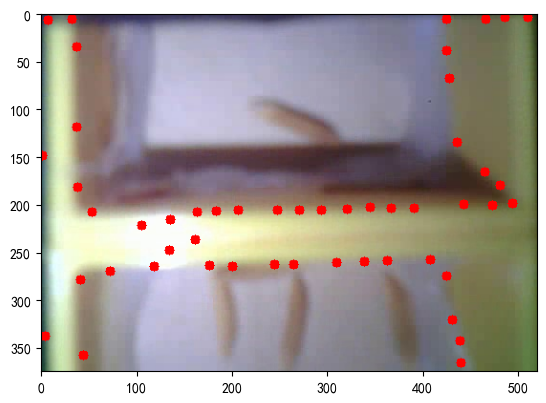

In [127]:
roi_hsv_mask = hsv_mask[y:y+h, x:x+w]
# 以掩码来检测得到角点
corners = cv2.goodFeaturesToTrack(roi_hsv_mask, maxCorners=50, 
                                 qualityLevel=0.05, 
                                 minDistance=20,
                                 blockSize=3)

if corners is not None:
    corners = np.int64(corners)
    print(f"检测到角点数量: {len(corners)}个")    
    # 在ROI上绘制角点
    roi_with_corners = roi.copy()
    for corner in corners:
        x_c, y_c = corner.ravel()
        cv2.circle(roi_with_corners, (x_c, y_c), 5, (0, 0, 255), -1)  # 红色圆点标记
        
    cv2.imshow('ROI with Corners', roi_with_corners)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

rgb_roi_with_corners = cv2.cvtColor(roi_with_corners, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_roi_with_corners)
plt.show()

### 4.2 特征点提取

检测到特征点数量: 130个


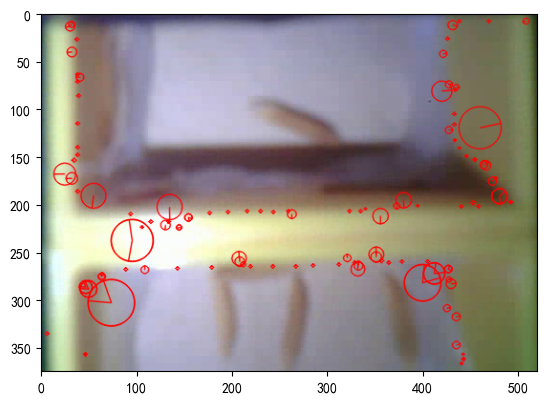

In [118]:
# 使用SIFT特征点提取器
sift = cv2.SIFT_create()

# 使用SIFT检测关键点和描述符
keypoints, descriptors = sift.detectAndCompute(roi_hsv_mask, None)

# 检查是否检测到特征点
if keypoints:
    print(f"检测到特征点数量: {len(keypoints)}个")

    # 在图像上绘制特征点
    roi_with_keypoints = roi.copy()

    # 绘制关键点
    roi_with_keypoints = cv2.drawKeypoints(roi_with_keypoints, keypoints, None, color=(0, 0, 255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # 显示带特征点的图像
    cv2.imshow('ROI with Keypoints', roi_with_keypoints)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # 使用matplotlib显示RGB图像
    rgb_roi_with_keypoints = cv2.cvtColor(roi_with_keypoints, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_roi_with_keypoints)
    plt.show()
else:
    print("没有检测到特征点")

### 4.3 直线检测

In [58]:
corners[:5]

array([[[193, 327]],

       [[249, 342]],

       [[581, 304]],

       [[222, 353]],

       [[132, 463]]], dtype=int64)

组内点数: 6
组内点数: 2 不符合要求
组内点数: 1 不符合要求
组内点数: 1 不符合要求
组内点数: 1 不符合要求
组内点数: 1 不符合要求
组内点数: 1 不符合要求
组内点数: 2 不符合要求
组内点数: 14
组内点数: 1 不符合要求
组内点数: 1 不符合要求
组内点数: 1 不符合要求
组内点数: 1 不符合要求
组内点数: 9
组内点数: 1 不符合要求
组内点数: 2 不符合要求
组内点数: 1 不符合要求
组内点数: 1 不符合要求
组内点数: 1 不符合要求
组内点数: 1 不符合要求
组内点数: 1 不符合要求


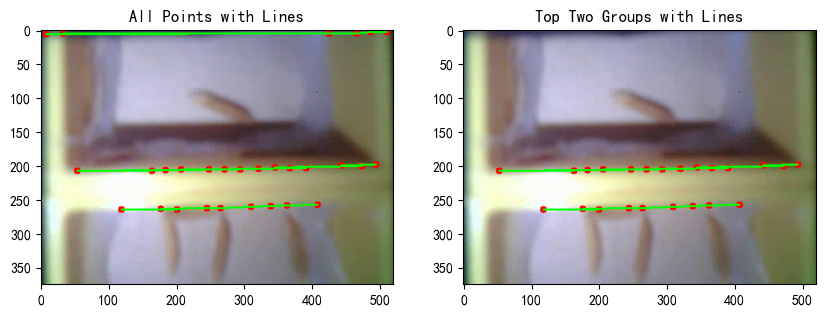

In [133]:
# 将角点转换为 (n, 2) 数组
points = corners.reshape(-1, 2)

# 按照 y 坐标从大到小对点进行排序
sorted_points = points[np.argsort(points[:, 1])[::-1]]  # [::-1] 使其按照 y 值从大到小排序

# 获取所有点的 y 坐标
y_coordinates = sorted_points[:, 1]

# 设置允许的 y 坐标偏差
y_tolerance = 4  # 设置偏差值， 个像素的偏差认为是"在一起"的点

# 聚合 y 坐标相差小于 5 像素的点
aggregated_points = []
current_group = [sorted_points[0]]

for i in range(1, len(sorted_points)):
    # 获取相邻点的 y 坐标差异
    if abs(sorted_points[i, 1] - sorted_points[i - 1, 1]) <= y_tolerance:
        current_group.append(sorted_points[i])
    else:
        aggregated_points.append(current_group)
        current_group = [sorted_points[i]]

# 将最后一组加入
aggregated_points.append(current_group)

# 输出每组的点数
i = len(aggregated_points) - 1
while i >= 0:
    group = aggregated_points[i]
    if len(group) <= 5:
        print(f"组内点数: {len(group)} 不符合要求")
        del aggregated_points[i]
    else:
        print(f"组内点数: {len(group)}")
    i -= 1  # 继续向前遍历

# 按照组内点数从大到小排序，选择前两个组
top_two_groups = sorted(aggregated_points, key=len, reverse=True)[:2]

# 创建原始图像副本
frame_with_lines = roi.copy()

# 遍历聚合的点组，绘制所有点及其连线
for group in aggregated_points:
    if len(group) > 1:
        # 绘制该组中的所有点
        for point in group:
            x, y = point
            cv2.circle(frame_with_lines, (x, y), 5, (0, 0, 255), -1)  # 红色圆点标记

        # 绘制水平线，连接该组的点
        for i in range(len(group) - 1):
            x1, y1 = group[i]
            x2, y2 = group[i + 1]
            cv2.line(frame_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 绿色线段

# 创建新图像绘制前两个最大组内点数的连线
frame_with_top_two_groups = roi.copy()

# 绘制前两个组的点
for group in top_two_groups:
    for point in group:
        x, y = point
        cv2.circle(frame_with_top_two_groups, (x, y), 5, (0, 0, 255), -1)  # 红色圆点标记

    # 绘制前两个组的水平线
    for i in range(len(group) - 1):
        x1, y1 = group[i]
        x2, y2 = group[i + 1]
        cv2.line(frame_with_top_two_groups, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 绿色线段

# 显示结果图像 - 所有点的连线
cv2.imshow('Close Points with Lines', frame_with_lines)
cv2.waitKey(0)

# 显示结果图像 - 前两个最大组的连线
cv2.imshow('Top Two Groups with Lines', frame_with_top_two_groups)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 如果你想在 matplotlib 中显示图像，可以将 BGR 图像转换为 RGB
rgb_frame_with_lines = cv2.cvtColor(frame_with_lines, cv2.COLOR_BGR2RGB)
rgb_frame_with_top_two_groups = cv2.cvtColor(frame_with_top_two_groups, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(rgb_frame_with_lines)
plt.title('All Points with Lines')

plt.subplot(1, 2, 2)
plt.imshow(rgb_frame_with_top_two_groups)
plt.title('Top Two Groups with Lines')

plt.show()

## 5. 格子的分割计数

In [92]:
top_two_groups

[[array([163, 208], dtype=int64),
  array([ 53, 208], dtype=int64),
  array([183, 207], dtype=int64),
  array([293, 206], dtype=int64),
  array([206, 206], dtype=int64),
  array([270, 206], dtype=int64),
  array([247, 206], dtype=int64),
  array([320, 205], dtype=int64),
  array([366, 204], dtype=int64),
  array([390, 204], dtype=int64),
  array([344, 203], dtype=int64),
  array([472, 201], dtype=int64),
  array([442, 200], dtype=int64),
  array([493, 199], dtype=int64)],
 [array([118, 265], dtype=int64),
  array([200, 265], dtype=int64),
  array([176, 264], dtype=int64),
  array([244, 263], dtype=int64),
  array([264, 263], dtype=int64),
  array([309, 261], dtype=int64),
  array([338, 260], dtype=int64),
  array([362, 259], dtype=int64),
  array([407, 258], dtype=int64)]]

### 5.1 分割线与面积差

y 最小值线与图片上方围成的面积: 138880
y 最大值线与图片下方围成的面积: 131840
面积差（上 - 下）：7040


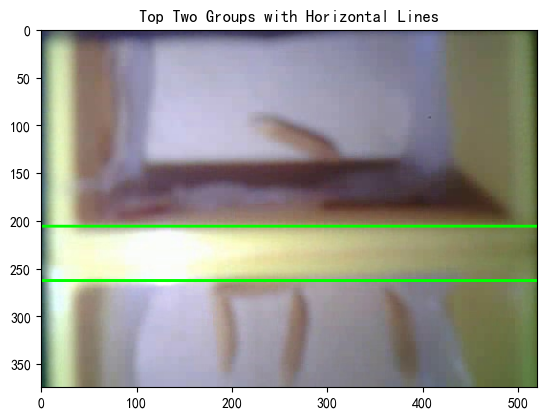

In [113]:
# 假设 roi 是原始图像的一个区域
frame_with_lines = roi.copy()

# 遍历前两组，计算每组的 y 坐标众数，并绘制对应的水平直线
y_max_value = None
y_min_value = None

for group in top_two_groups:
    # 获取所有 y 坐标
    y_coordinates = np.array([point[1] for point in group])

    # 使用 numpy 计算众数：首先找到唯一的 y 值及其出现次数
    unique_y, counts = np.unique(y_coordinates, return_counts=True)

    # 找到出现次数最多的 y 坐标
    most_common_y_value = unique_y[np.argmax(counts)]

    # 保存较大的 y 和较小的 y 坐标
    if y_max_value is None or most_common_y_value > y_max_value:
        y_max_value = most_common_y_value
    if y_min_value is None or most_common_y_value < y_min_value:
        y_min_value = most_common_y_value

    # 获取图像宽度（即 x 坐标的范围）
    x_min = 0  # 图像左侧
    x_max = frame.shape[1]  # 图像右侧（宽度）

    # 绘制水平直线，贯穿整个图像
    cv2.line(frame_with_lines, (x_min, most_common_y_value), (x_max, most_common_y_value), (0, 255, 0), 2)  # 绿色直线

# 显示结果图像 - 前两个最大组的水平直线
cv2.imshow('Top Two Groups with Horizontal Lines', frame_with_lines)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 计算面积：
height = frame.shape[0]  # 图像的高度

# 面积1: y_max_value 与图像顶部围成的矩形
area_top = x_max * (height - y_max_value)

# 面积2: y_min_value 与图像底部围成的矩形
area_bottom = x_max * y_min_value

print(f"y 最小值线与图片上方围成的面积: {area_top}")
print(f"y 最大值线与图片下方围成的面积: {area_bottom}")
print(f"面积差（上 - 下）：{area_top - area_bottom}")

# 如果你想在 matplotlib 中显示图像，可以将 BGR 图像转换为 RGB  
"""
    opencv的原点是在左上角
    matplotlib的原点是在左下角
"""
rgb_frame_with_lines = cv2.cvtColor(frame_with_lines, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_frame_with_lines)
plt.title('Top Two Groups with Horizontal Lines')
plt.show()

### 5.2 编号分配

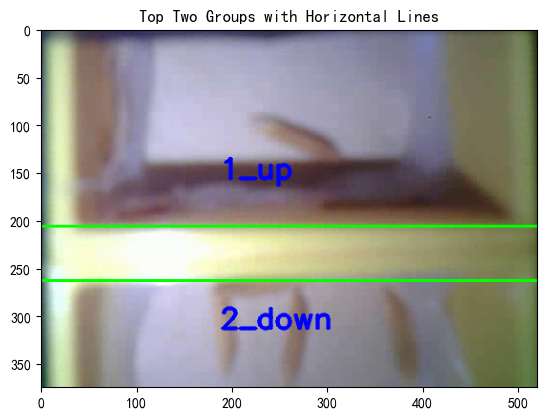

In [117]:
# 标记面积1和面积2
# 面积1: y_max_value 与图像顶部围成的矩形
cv2.putText(frame_with_lines, '2_down', (int(frame_with_lines.shape[0]//2), int(y_max_value+50)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
# 面积2: y_min_value 与图像底部围成的矩形
cv2.putText(frame_with_lines, '1_up', (int(frame_with_lines.shape[0]//2), int(y_min_value)-50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

# 显示结果图像 - 前两个最大组的水平直线和标记
cv2.imshow('Top Two Groups with Horizontal Lines and Area Marked', frame_with_lines)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 如果你想在 matplotlib 中显示图像，可以将 BGR 图像转换为 RGB
rgb_frame_with_lines = cv2.cvtColor(frame_with_lines, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_frame_with_lines)
plt.title('Top Two Groups with Horizontal Lines')
plt.show()